In [2]:
from emlp.nn import MLP,EMLP,MLPH,EMLPH
import matplotlib.pyplot as plt
import seaborn as sns
import objax
from rpp.objax import MixedEMLP, MixedEMLPH
import jax.numpy as jnp
import numpy as np
from oil.datasetup.datasets import split_dataset

from torch.utils.data import DataLoader
import os
import sys
sys.path.append("../")
sys.path.append("../trainer/")
sys.path.append("../trainer/")
from utils import LoaderTo
from datasets import ModifiedInertia, Inertia
from jax import vmap
from emlp.reps import Scalar

import pandas as pd

In [3]:
ndata=1000+2000
seed=2021

bs = 500

mod_dset = ModifiedInertia(3000) # Initialize dataset with 1000 examples
vanilla_dset = Inertia(3000)

split={'train':-1,'val':1000,'test':1000}
datasets = split_dataset(mod_dset,splits=split)
dataloaders = {k:LoaderTo(DataLoader(v,batch_size=min(bs,len(v)),shuffle=(k=='train'),
        num_workers=0,pin_memory=False)) for k,v in datasets.items()}
mod_trainloader = dataloaders['train']
mod_testloader = dataloaders['test']

datasets = split_dataset(vanilla_dset,splits=split)
dataloaders = {k:LoaderTo(DataLoader(v,batch_size=min(bs,len(v)),shuffle=(k=='train'),
        num_workers=0,pin_memory=False)) for k,v in datasets.items()}
vanilla_trainloader = dataloaders['train']
vanilla_testloader = dataloaders['test']



G = vanilla_dset.symmetry

In [4]:
def namer(modified, epoch, trial):
    name = "./saved-outputs/inertia_basic0.1_equiv0.0001/"
    if modified:
        name += "modifiedinertia_"
    else:
        name += "inertia_"
    
    name += "model_epoch" + str(epoch) + "_trial" + str(trial) + ".npz"
    return name

In [5]:
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#

def scale_adjusted_rel_err(a,b,g):
    return  jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean())+jnp.abs(g-jnp.eye(g.shape[-1])).mean())

def equivariance_err(model,mb,group=None):
    x,y = mb
    group = model.G if group is None else group
    gs = group.samples(x.shape[0])
    rho_gin = vmap(model.rep_in.rho_dense)(gs)
    rho_gout = vmap(model.rep_out.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0])
    y2 = (rho_gout@model(x)[...,None])[...,0]
    return np.asarray(scale_adjusted_rel_err(y1,y2,gs))

def mse(mdl, x, y):
    yhat = mdl(x)
    return ((yhat-y)**2).mean()

In [5]:
epochs = [ii * 5 for ii in range(1, 20)] + [99]
logger = []


for trial in range(10):
    model = MixedEMLP(vanilla_dset.rep_in, vanilla_dset.rep_out, group=G,num_layers=3,ch=384)
    mod_equiv_err = np.mean([equivariance_err(model, mb) for mb in vanilla_testloader])
    
    model = MixedEMLP(vanilla_dset.rep_in, vanilla_dset.rep_out, group=G,num_layers=3,ch=384)
    vanilla_equiv_err = np.mean([equivariance_err(model, mb) for mb in vanilla_testloader])
    
    logger.append([0, trial, mod_equiv_err, vanilla_equiv_err])
    

In [7]:
for trial in range(10):
    for epoch in epochs:
        fname = namer(True, epoch, trial)
        objax.io.load_var_collection(fname,
                            model.vars())
        mod_equiv_err = np.mean([equivariance_err(model, mb) for mb in vanilla_testloader])
        
        fname = namer(False, epoch, trial)
        objax.io.load_var_collection(fname,
                            model.vars())
        vanilla_equiv_err = np.mean([equivariance_err(model, mb) for mb in vanilla_testloader])
        
        logger.append([epoch, trial, mod_equiv_err, vanilla_equiv_err])

In [ ]:
full_df = pd.DataFrame(logger)
full_df.columns = ['epoch', 'trial', 'mod_equiv_err', "vanilla_equiv_err"]
full_df.to_pickle("./ensemble_plotter.pkl")

## Plot

In [6]:
full_df = pd.read_pickle("./ensemble_plotter.pkl")

In [7]:
from joypy import joyplot

In [8]:
temp_df = full_df[(full_df['epoch'] == 5) |  (full_df['epoch'] == 15) | (full_df['epoch'] == 30)]
temp_df['logmod'] = np.log(temp_df['mod_equiv_err'].to_numpy())
temp_df['logvan'] = np.log(temp_df['vanilla_equiv_err'].to_numpy())

<ipython-input-8-f569d44f8402>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['logmod'] = np.log(temp_df['mod_equiv_err'].to_numpy())
<ipython-input-8-f569d44f8402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['logvan'] = np.log(temp_df['vanilla_equiv_err'].to_numpy())


In [9]:
full_df['logmod'] = np.log(full_df['mod_equiv_err'].to_numpy())
full_df['logvan'] = np.log(full_df['vanilla_equiv_err'].to_numpy())

In [10]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

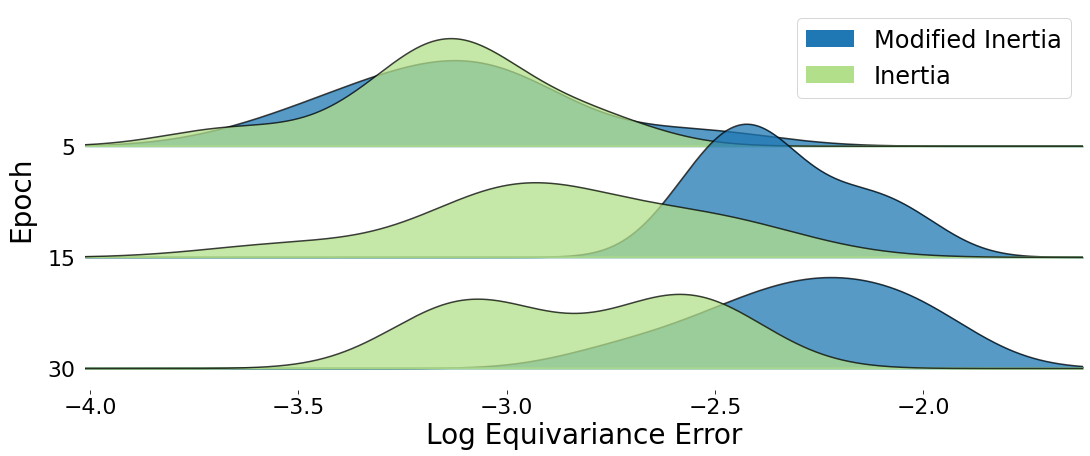

In [14]:
fs = 24
fig, axes = joyplot(
    data=temp_df[['epoch', 'logmod', 'logvan']], 
    by='epoch',
    column=['logvan', 'logmod'],
    color=['#1f78b4', '#b2df8a'],
    legend=True,
    alpha=0.75,
    figsize=(15, 6),
#     xlabel="Log Equivariance Error",
    xlabelsize=fs-2,
#     ylabel="Epoch",
    ylabelsize=fs-2
)

patches = [Patch(facecolor='#1f78b4', edgecolor=None,
                         label="Modified Inertia"),
           Patch(facecolor='#b2df8a', edgecolor=None,
                         label="Inertia")]
           

axes[0].legend(handles=patches, fontsize=fs)
axes[-1].set_xlabel("Log Equivariance Error", fontsize=fs+4)
axes[-1].xaxis.set_visible(True)
axes[-1].set_ylabel("Epoch", fontsize=fs+4, labelpad=50)
axes[-1].set_yticks([])
axes[-1].yaxis.set_visible(True)
plt.savefig("./posterior_sample.pdf", bbox_inches='tight')
# fig.ylabel("Epoch")

In [60]:
ax[0].legend()